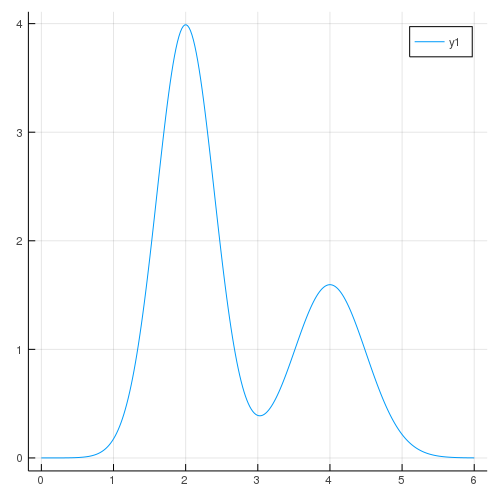

In [1]:
include("../src/StatReg.jl")
using .StatReg
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)
using QuadGK

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

myplot = plot(x, phi.(x))

In [2]:
using QuadGK

kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise;

# plot(y, f, title="Integrated function",label=["f(y)"],seriestype=:scatter, yerr=sig)
# savefig("integrated.png")

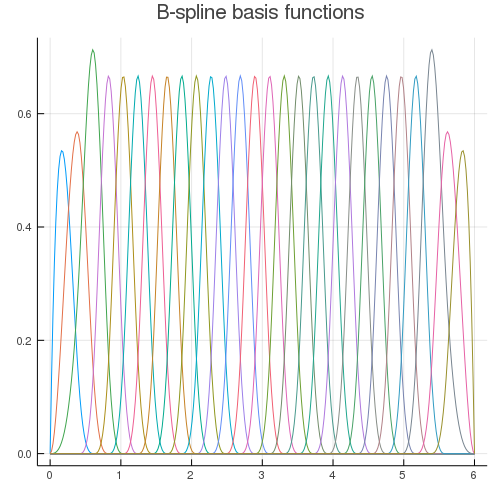

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:101


In [3]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [13]:
kernel_matrix = discretize_kernel(basis, kernel, y)
Omega = omega(basis, 2)
model = MCMCMatrixUnfolder([Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3]);
model_1 = GaussErrorMatrixUnfolder([Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3]);

┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: MCMCMatrixUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/mcmc.jl:56
┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:55


In [18]:
# using Mamba
# args = solve(model, kernel_matrix, f, sig, model="Gaussian", samples=1 * 1000, chains=8);
args_1 = solve(model_1, kernel_matrix, f, sig);
# sim = mcmc(args[1]...; args[2]...)
# result = get_values(sim)
# println()

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:85
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 4 chains successful after 2 cycle(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:109


alphas = [0.0939774]


┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:103


Dict{String,AbstractArray{Float64,N} where N} with 3 entries:
  "errors" => [0.0282686 0.0139409 … 7.80242e-6 4.56687e-6; 0.0139409 0.0623929…
  "alphas" => [0.0939774]
  "coeff"  => [-0.0720388, -0.195252, -0.108069, 0.158089, 0.632719, 1.25348, 1…

In [6]:
# phivec = PhiVec(args[1], basis, args[2])

# phi_reconstructed = phivec.phi_function.(x)
# phi_reconstructed_errors = phivec.error_function.(x)

# plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
# plot!(x, phi.(x), label="Real function")
# savefig("reconstructed.png")

In [7]:
samples = args[1];

In [8]:
coeff = [mean([samples[j][i] for j in range(1, stop=1_000)]) for i in eachindex(samples[1])]

28-element Array{Float64,1}:
  0.770943623766167   
 -3.962782435473594   
  6.111677540245859   
 -6.850792628301471   
  2.0661081725817643  
  2.01048085109723    
  0.1975312051079355  
 -0.08009162462311391 
 -0.4851935776959051  
 -0.48443774244731785 
  0.16216545016664685 
  0.019028712692155628
  0.27021580153757524 
  ⋮                   
 -0.16174294304443435 
  0.2605350427157644  
 -0.29328127762714234 
  0.2134168385855097  
  0.02364323561652484 
  0.3937637332386924  
  0.8724157248120106  
  1.1616255817486605  
 -5.790092198279834   
  5.71364688235428    
 -2.833340692285656   
 -0.29304291110319236 

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:45


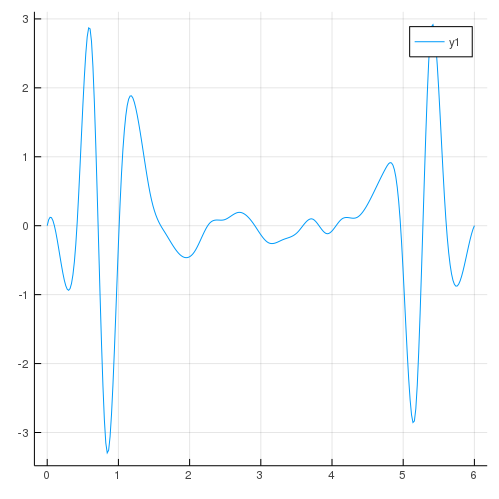

In [9]:
phivec = PhiVec(coeff, basis)
phi_reconstructed = phivec.phi_function.(x)

plot(x, phi_reconstructed)

In [10]:
coeff_ = [[samples[j][i] for j in range(1, stop=1000)] for i in eachindex(samples[1])];

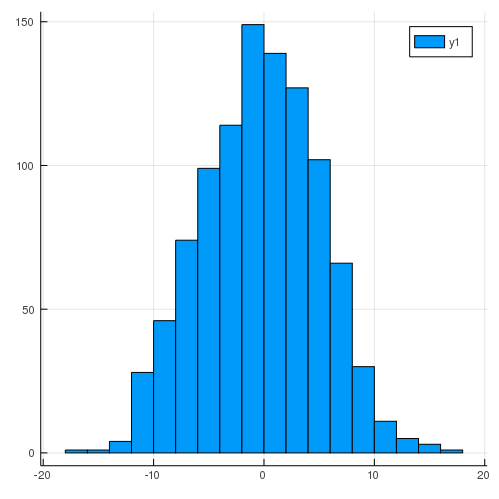

In [11]:
histogram(coeff_[19])

In [15]:
args_1

UndefVarError: UndefVarError: args_1 not defined

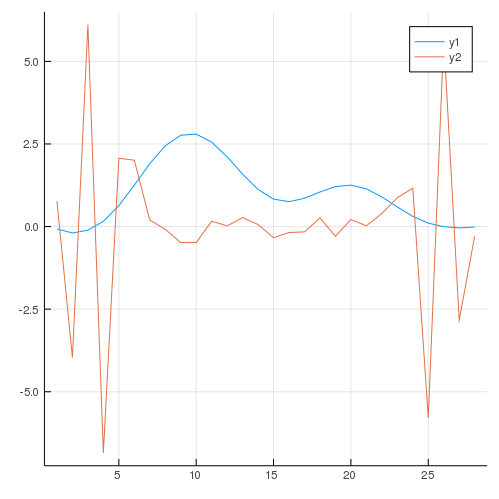

In [24]:
plot(args_1["coeff"])
plot!(coeff)